In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io


# from tqdm import tqdm_notebook 
from tqdm.notebook import tqdm 
import random

import sentencepiece as spm
from konlpy.tag import Mecab

print(tf.__version__)
print(np.__version__)

2.8.0
1.23.5


# Step 1. 데이터 불러오기
   

In [2]:
# train data load
data_dir = os.getenv('HOME')+'/aiffel/DATA' # 파일 경로 지정
data_train_path = data_dir+"/data_train_spm_4000.pkl"
data_test_path = data_dir+"/data_test_spm_4000.pkl"
full_data = pd.read_pickle(data_train_path, 'gzip')
full_data_test = pd.read_pickle(data_test_path, 'gzip')

In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229210 entries, 0 to 1229209
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   toks_en     1229210 non-null  object
 1   toks_dec    1229210 non-null  object
 2   source_txt  1229210 non-null  object
 3   target_txt  1229210 non-null  object
 4   topic       1229210 non-null  object
 5   reg         1229210 non-null  object
dtypes: object(6)
memory usage: 56.3+ MB


In [4]:
full_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   toks_en     1500 non-null   object
 1   toks_dec    1500 non-null   object
 2   source_txt  1500 non-null   object
 3   target_txt  1500 non-null   object
 4   topic       1500 non-null   object
 5   reg         1500 non-null   object
dtypes: object(6)
memory usage: 70.4+ KB


In [5]:
regs = full_data.reg.unique()

In [6]:
full_data['tok_len'] = full_data['toks_en'].apply(lambda x : len(x))

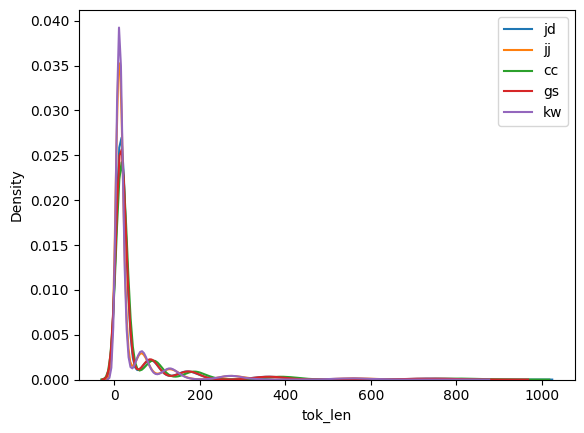

In [7]:
import seaborn as sns
for reg in regs :
    sns.kdeplot(x='tok_len',data = full_data.loc[full_data['reg']==reg], label =reg)
plt.legend()
plt.show()
#     print(f'Dial_{reg} :', count)

In [8]:
full_data.groupby(full_data['reg'])['tok_len'].mean()

reg
cc    58.982203
gs    54.768612
jd    54.630054
jj    42.597886
kw    42.651872
Name: tok_len, dtype: float64

# Step 2. 데이터 정제 및 토큰화

In [9]:
SRC_VOCAB_SIZE = 4009
TGT_VOCAB_SIZE = 4009

enc_tokenizer = spm.SentencePieceProcessor()
enc_tokenizer.Load('spm_enc_v.model')

dec_tokenizer = spm.SentencePieceProcessor()
dec_tokenizer.Load('spm_dec_v.model')

dec_tokenizer.set_encode_extra_options("bos:eos")

True

In [10]:
src_corpus = full_data['toks_en'].values
tgt_corpus = full_data['toks_dec'].values
src_valid_corpus = full_data_test['toks_en'].values
tgt_valid_corpus = full_data_test['toks_dec'].values

In [11]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
max_len = 256
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post', maxlen=max_len)
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post', maxlen=max_len)
enc_test = tf.keras.preprocessing.sequence.pad_sequences(src_valid_corpus, padding='post', maxlen=max_len)
dec_test = tf.keras.preprocessing.sequence.pad_sequences(tgt_valid_corpus, padding='post', maxlen=max_len)

In [12]:
# enc, dec 의 seq_length는 달라도 상관없음.
print(enc_train.shape)
print(dec_train.shape)
print(enc_test.shape)
print(dec_test.shape)

(1229210, 256)
(1229210, 256)
(1500, 256)
(1500, 256)


# Step 3. 모델불러오기

In [13]:
import wandb
wandb.login()

wandb: Currently logged in as: seuyon0101. Use `wandb login --relogin` to force relogin


True

In [14]:
#wandb 설정
run  = wandb.init(project = 'PRJ_saturi_model_exp1',
                 entity = 'saturi',
                 config = {
                     'model_name':'Vanilla_Transformer_bpe_40009',
                     'n_layers':6,
                     'd_model':512,
                     'n_heads':8,
                     'd_ff':2048,
                     'src_vocab_size':SRC_VOCAB_SIZE,
                     'tgt_vocab_size':TGT_VOCAB_SIZE,
                     'pos_len':max_len,
                     'dropout':0.2,
                     'shared':True,
                     'batch_size':32,
                     'warmups' : 4000,
                     'epochs':1,
                     'optimizer' :'ADAM',
                     'loss' : 'SparseCategoricalCrossentropy',
                     'metric' : 'bleu'
                     
                 })
config = wandb.config

wandb: Currently logged in as: seuyon0101 (saturi). Use `wandb login --relogin` to force relogin


In [15]:
import sys
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/MODEL/') # vanilla transformer 파일경로에서 불러오기 위해 설정
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/PRE/')
sys.path.insert(0,os.getenv('HOME') + '/aiffel/saturi/POST/')

In [16]:
from vanilla_transformer import Transformer, generate_masks

transformer = Transformer(
    n_layers=config.n_layers,
    d_model=config.d_model,
    n_heads=config.n_heads,
    d_ff=config.d_ff,
    src_vocab_size=config.src_vocab_size,
    tgt_vocab_size=config.tgt_vocab_size,
    pos_len=config.pos_len,
    dropout=config.dropout,
    shared=config.shared
)

2023-03-15 15:00:39.350358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 15:00:39.393193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 15:00:39.393435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 15:00:39.394062: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

##  Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언

In [17]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=config.warmups):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** np.array(-0.5)
        arg2 = step * np.array(self.warmup_steps ** -1.5)
        
        return np.array(self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [18]:
learningrate = LearningRateScheduler(256)

In [19]:
optimizer = tf.keras.optimizers.Adam(learningrate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss 함수를 정의


In [20]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## train_step 함수를 정의


In [21]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return loss, enc_attns, dec_attns, dec_enc_attns, predictions

In [22]:
# Validating the model
@tf.function
def model_validate(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    v_loss = loss_function(gold, predictions[:, :-1])
    
    return v_loss, predictions

In [25]:
# 학습 매니저 설정
from evaluation import evaluate, compute_metric

def train_and_checkpoint(transformer, manager, EPOCHS):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    
    else:
        print("Initializing from scratch.")


    for epoch in range(EPOCHS):
        total_loss = 0
        total_loss_val = 0
        bleu_train = 0
        bleu_valid = 0
        

        idx_list = list(range(0, enc_train.shape[0], config.batch_size))
        random.shuffle(idx_list)
        t = tqdm(idx_list)
        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns, preds = train_step(enc_train[idx:idx+config.batch_size],
                                                                         dec_train[idx:idx+config.batch_size],
                                                                         transformer,
                                                                         optimizer)

            total_loss += batch_loss
            
            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
#             gold = dec_train[idx:idx+config.batch_size]
#             bleu_train += compute_metric(preds,gold, dec_tokenizer)
            
            
        #validation
        for test_idx in range(0,enc_test.shape[0], config.batch_size) :
            val_loss, val_preds = model_validate(enc_test[test_idx : test_idx + config.batch_size],
                                      dec_test[test_idx : test_idx + config.batch_size],
                                      transformer)
            total_loss_val += val_loss
            val_gold = dec_test[test_idx:test_idx+config.batch_size]
            bleu_valid += compute_metric(val_preds.numpy(),val_gold,dec_tokenizer)

        wandb.log({"train_loss": total_loss.numpy() / (len(t) + 1),
                   "valid_loss" : total_loss_val.numpy() / enc_test.shape[0],
                   "valid_bleu" : bleu_valid / enc_test.shape[0]})

        save_path = manager.save()
        print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
        
directory = os.getenv('HOME') + '/aiffel/MODEL/'
ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer , transformer = transformer)
manager = tf.train.CheckpointManager(ckpt, directory +'tf_ckpt_t4000_v1',max_to_keep=3)

## 학습

In [ ]:
train_and_checkpoint(transformer, manager, config.epochs)

Initializing from scratch.


  0%|          | 0/38413 [00:00<?, ?it/s]

# Step 5. 평가

In [ ]:
from evaluation import translate

In [ ]:
examples = ["<jj> what are you eating?",'<cc> what are you eating?','<gs> what are you eating?','<jd> what are you eating?','<kw> what are you eating?']

In [ ]:
for example in examples :
    translate(example, transformer, enc_tokenizer, dec_tokenizer, max_len, verbose =True)

In [ ]:
src = enc_test[0:10]
tgt = dec_test[0:10]
enc_mask, dec_enc_mask, dec_mask = generate_masks(src[:10], tgt[:10])
predictions, enc_attns, dec_attns, dec_enc_attns = transformer(src, tgt, enc_mask, dec_enc_mask, dec_mask)
compute_metric(predictions, tgt, dec_tokenizer)

In [ ]:
wandb.finish()